### QED-C Application-Oriented Benchmarks - Hamiltonian Simulation with HamLib - GSEE / VQE

The notebook contains specific examples for the HamLib-based Hamiltonian Simulation benchmark program.
Configure and run the cell below with the desired execution settings.
Then configure and run the remaining cell(s), each one a variation of this benchmark.

This example illustrates finding the ground state energy of a Hamiltonian extracted from the specified HamLib dataset.
It uses a typical classical optimizer to itertively execute a parameterized quantum ansatz kernel and to progressively adjust the ansatz parameters to find the lowest energy state for the Hamiltonian.

Currently this example operates on only one fixed size for each type of Hamiltonian and produces plots representing the evolution of the optimization.



### Program Configuration

In [1]:
# Select the API to use and load the benchmark program
api = "qiskit"
import hamlib_simulation_benchmark

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 6
skip_qubits=1
max_circuits=1
num_shots=10000

# Select the backend 
#backend_id="qasm_simulator"
backend_id="statevector_simulator"
provider_backend=None
exec_options={}

#############

# place resulting data and images into a folder with "paper" suffix
import metrics
metrics.data_suffix = "_vqe"
hamlib_simulation_benchmark.data_suffix = "_vqe"


In [2]:
import numpy as np
from math import sin, cos, pi
import time

# Configure module paths
import sys
sys.path.insert(1, "_common")
sys.path.insert(1, "qiskit")

# Import HamLib helper functions (from _common)
import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
import hamlib_simulation_kernel

# Import Observable helper functions
import observables
import evolution_exact

verbose = True

#### for executing circuits to compute observables ...

# Import Qiskit and Qiskit Pauli operator classes
#from qiskit.quantum_info import Pauli, SparsePauliOp
#from qiskit import QuantumCircuit

# Initialize simulator backend
#from qiskit_aer import Aer
#backend = Aer.get_backend('qasm_simulator')


### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# list of observable computation methods to sweep
group_method_list = [ None, "simple", "N", "estimator" ]

# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation
hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# limit testing to simple for now
group_method = "simple"

# just do TFIM for now
ham_indexes = [ 0 ]

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[0]

print(f"\n*******************************************************************************************")

print(f"\nHamiltonianGSEE / VQE Example for {hamiltonian_name} {hamiltonian_params}\n")

print("============================================================\n")
print(f"Testing expectation grouping method: {group_method}\n") 



*******************************************************************************************

HamiltonianGSEE / VQE Example for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


Testing expectation grouping method: simple



### Load the Given Hamiltonian to get its Pauli terms

In [4]:
# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
print(f"... dataset_name = {dataset_name}")
print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")

print("")

... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-6_h-2
... sparse_pauli_terms = 
[({0: 'Z', 1: 'Z'}, (1+0j)), ({0: 'Z', 5: 'Z'}, (1+0j)), ({1: 'Z', 2: 'Z'}, (1+0j)), ({5: 'Z', 4: 'Z'}, (1+0j)), ({2: 'Z', 3: 'Z'}, (1+0j)), ({3: 'Z', 4: 'Z'}, (1+0j)), ({0: 'X'}, (2+0j)), ({1: 'X'}, (2+0j)), ({5: 'X'}, (2+0j)), ({2: 'X'}, (2+0j)), ({3: 'X'}, (2+0j)), ({4: 'X'}, (2+0j))]



In [5]:
def find_pauli_groups(num_qubits, sparse_pauli_terms, group_method):
    
    print(f"... using group method: {group_method}")

    ts = time.time()
    
    # use no grouping or the most basic method "simple"
    if group_method == None or group_method == "simple":
    
        # Flag to control optimize by use of commuting groups
        use_commuting_groups = False
        if group_method == "simple":
            use_commuting_groups = True
    
        # group Pauli terms for quantum execution, optionally combining commuting terms into groups.
        pauli_term_groups, pauli_str_list = observables.group_pauli_terms_for_execution(
                num_qubits, sparse_pauli_terms, use_commuting_groups)
    
    # use k-commuting algorithm
    else:
        from generate_pauli_groups import compute_groups
        pauli_term_groups = compute_groups(num_qubits, sparse_pauli_terms, 1)
    
    print(f"\n... Number of groups created: {len(pauli_term_groups)}")
    print(f"... Pauli Term Groups:")
    for group in pauli_term_groups:
        print(group)
    
    group_time = round(time.time()-ts, 3)
    print(f"\n... finished grouping terms, total grouping time = {group_time} sec.\n")
    
    # for each group, create a merged pauli string from all the terms in the group
    # DEVNOTE: move these 4 lines to a function in observables
    pauli_str_list = []
    for group in pauli_term_groups:
        merged_pauli_str = observables.merge_pauli_terms(group, num_qubits)
        pauli_str_list.append(merged_pauli_str)
    
    print(f"\n... Merged Pauli strings, one per group:\n  {pauli_str_list}\n")

    return pauli_term_groups, pauli_str_list

pauli_term_groups, pauli_str_list = find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)
    

... using group method: simple

... Number of groups created: 2
... Pauli Term Groups:
[('ZZIIII', (1+0j)), ('ZIIIIZ', (1+0j)), ('IZZIII', (1+0j)), ('IIIIZZ', (1+0j)), ('IIZZII', (1+0j)), ('IIIZZI', (1+0j))]
[('XIIIII', (2+0j)), ('IXIIII', (2+0j)), ('IIIIIX', (2+0j)), ('IIXIII', (2+0j)), ('IIIXII', (2+0j)), ('IIIIXI', (2+0j))]

... finished grouping terms, total grouping time = 0.0 sec.


... Merged Pauli strings, one per group:
  ['ZZZZZZ', 'XXXXXX']



### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

In [6]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit

def get_ansatz(num_qubits, params):
    ansatz = EfficientSU2(num_qubits).decompose()
    ansatz.barrier()

    params_dict = {p: params[i] for i, p in enumerate(ansatz.parameters)}

    # Use assign_parameters instead of bind_parameters
    ansatz = ansatz.assign_parameters(params_dict)
    
    return ansatz

# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)
print(ansatz_circuit)


[ 0.307  1.352  0.646  0.282 -0.48   0.917 -0.392  2.462  2.913 -0.732
  1.833  0.182  0.428  2.674 -2.695 -2.594 -3.015  2.09   1.748  2.325
  3.007  1.88  -0.242  1.763 -2.398  0.879 -2.241  2.794  0.137 -0.536
 -1.479  1.723 -0.276  0.43  -3.024  0.739  0.704  0.735  2.788  1.142
 -0.883 -0.396  1.242 -2.763  1.048  1.072 -1.82  -2.332]
      ┌────────────┐ ┌──────────────┐                                  »
q_0: ─┤ Ry(0.3067) ├─┤ Rz(-0.39215) ├──────────────────────────────────»
      ├────────────┤ └┬────────────┬┘                                  »
q_1: ─┤ Ry(1.3521) ├──┤ Rz(2.4616) ├───────────────────────────────────»
     ┌┴────────────┤  ├────────────┤                                   »
q_2: ┤ Ry(0.64568) ├──┤ Rz(2.9133) ├───────────────────────────■───────»
     ├─────────────┤ ┌┴────────────┴┐                        ┌─┴─┐     »
q_3: ┤ Ry(0.28201) ├─┤ Rz(-0.73236) ├───────────■────────────┤ X ├─────»
     ├─────────────┴┐└┬───────────┬─┘         ┌─┴─┐     ┌────┴───┴────┐»
q

### Create Measurement Circuits from Base Circuit and Pauli Terms
Here, we append basis rotation gates for each Pauli Term group to the base evolution circuit to create an array of circuits for execution.

In [7]:
# generate an array of circuits, one for each pauli_string in list
def create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list):
    ts = time.time()
    
    circuits = hamlib_simulation_kernel.create_circuits_for_pauli_terms(qc, num_qubits, pauli_str_list)
    """
    print(f"... Appended {len(circuits)} circuits, one for each group:")               
    for circuit, group in list(zip(circuits, pauli_term_groups)):
        print(group)
        #print(circuit)
    """
    append_time = round(time.time()-ts, 3)
    ###print(f"\n... finished appending {len(circuits)} measurement circuits, total creating time = {append_time} sec.\n")

    return circuits


In [8]:
def do_execute(circuits, num_shots):
    
    # Initialize simulator backend
    from qiskit_aer import Aer
    backend = Aer.get_backend('qasm_simulator')
    #backend = Aer.get_backend('statevector_simulator')     # doesn't work, only returns 1 shot
    
    ### print(f"... begin executing {len(circuits)} circuits ...")
    ts = time.time()
    
    # Execute all of the circuits to obtain array of result objects
    results = backend.run(circuits, num_shots=num_shots).result()

    #for ca in results.get_counts():
    #    print(ca)
    
    exec_time = round(time.time()-ts, 3)
    ###print(f"... finished executing {len(circuits)} circuits, total execution time = {exec_time} sec.\n")

    return results


In [9]:
# Compute the total energy for the Hamiltonian
def compute_energy(num_qubits, results, pauli_term_groups):

    ###print(f"... begin computing observable value ...")
    ts = time.time()
    
    total_energy, term_contributions = observables.calculate_expectation_from_measurements(
                                                num_qubits, results, pauli_term_groups)
    obs_time = round(time.time()-ts, 3)
    ###print(f"... finished computing observable value, computation time = {obs_time} sec.\n")
    
    print(f"    Total Energy: {round(np.real(total_energy), 4)}")
    ### print(f"    Term Contributions: {term_contributions}\n")

    create_time = 0
    group_time = 0
    append_time = 0
    exec_time = 0
    
    total_time = group_time + create_time + append_time + exec_time + obs_time
    total_time = round(total_time, 3)
    ###print(f"\n... total observable computation time = {total_time} sec.\n")
    
    return total_energy


### Define the Objective Function for the Classical Optimizer (Cost Function)
Now we specify the objective function which takes as input a list of the ansatz' parameters, and returns the cost associated with those parameters. The cost is determined by exeuting the ansatz with those parameters and computes a cost function based on the measurement distribution returned.

In the case of VQE, the ansatz needs to be executed once for each term of the Hamiltonian, with basis rotations applied at the end of the ansatz. The total energy is the sum of the weighted energy computation over all the terms. The goal is to find the parameters that result in the lowest 'total energy'. 

In [10]:
# keep track of the number of iterations performed
count = 0

tracker_style = 1     # controls style of output printed each iteration - 1 - dots, 2 - detailed

# Return the cost associated with the ansatz and the given parameters over the problem Hamiltonian
def objective_function(params):
    global count
    count += 1

    #print(num_qubits)
    
    # Create a quantum ansatz circuit with the given parameters (update later to use Parameter)
    qc = get_ansatz(num_qubits, params)  

    #print(qc)

    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list)

    #for c in circuits:
    #    print(c)

    results = do_execute(circuits, num_shots)

    energy = compute_energy(num_qubits, results, pauli_term_groups)

    return np.real(energy)
    

In [11]:
energy = objective_function(initial_params)

print(f"... energy = {round(energy, 4)}")



    Total Energy: -1.1758
... energy = -1.1758


### Execute the VQE Algorithm to Find the Optimal Parameters.
Create an instance of the selected optimizer, and run the algorithm. Note that the output varies from run to run. Moreover, while close, the obtained distribution might not be exactly the same as the target distribution, however, increasing the number of shots taken will increase the accuracy of the output.

In [14]:
from scipy.optimize import minimize

# Select the optimizer to use
#method = 'SLSQP'
#method = 'Nelder-Mead'
method = 'COBYLA'
maxiter = 500

global count
count = 0

# Create the initial parameters to match length of parameters
#params = np.random.rand(num_params)
params = np.random.uniform(-np.pi, np.pi, num_params)
params = [ 0.0 ] * num_params

#if initial_point is not None:
#    params = initial_point

initial_point = params

print(f"... init point = {initial_point}")

# Print header above output from execution
print("  Iter\tEnergy\t\tParams")

# Iterate over multiple executions of the objective_function to obtain lowest energy
result = minimize(objective_function, initial_point, method=method, options = { 'maxiter': maxiter} )

#print(f"\nExecution on backend = {backend}")
print(f"Final Result:{result}")

print(f"\nLowest Ground State Energy: ", result.fun)
print("Parameters Found: ", result.x)
print("Total Iterations: ", result.nfev)

... init point = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  Iter	Energy		Params
    Total Energy: 6.4219
    Total Energy: 5.1719
    Total Energy: 4.2695
    Total Energy: 3.4336
    Total Energy: 4.2539
    Total Energy: 2.8516
    Total Energy: 8.1406
    Total Energy: 2.9336
    Total Energy: 3.1953
    Total Energy: 3.125
    Total Energy: 3.5
    Total Energy: 2.9023
    Total Energy: 3.1016
    Total Energy: 2.1836
    Total Energy: 2.5352
    Total Energy: 1.125
    Total Energy: 1.8125
    Total Energy: 2.5469
    Total Energy: 2.8555
    Total Energy: 1.2773
    Total Energy: 1.0234
    Total Energy: 1.8867
    Total Energy: 1.3828
    Total Energy: 1.2344
    Total Energy: 0.8633
    Total Energy: 1.5117
    Total Energy: 1.2266
    Total Energy: 0.7695
    Total Energy: 0.7227


### Next cells pulled from elsewhere, need to be re-worked to draw plot


In [15]:
# Select the optimizer to use
#optimizer = SLSQP(maxiter=1000)
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Show comfort dots for each execution
tracker_style = 1

# Number of repetitions to do on each backend
NUM_REPS = 7

# Store an array of lowest energy results for each backend tested
energy_results = {}

for backend_label in backends:
    
    global backend, noise_model
    
    backend = backends[backend_label]
    if backend_label in noise_models:
        noise_model = noise_models[backend_label]
    else:
        noise_model = None

    print(f"\nExecution on backend = {backend_label}")

    energy_results[backend_label] = []

    for rep in range(NUM_REPS):
        global count
        count = 0

        # Create the initial parameters to match length of parameters
        params = np.random.rand(num_params)

        if initial_point is not None:
            params = initial_point

        # Print header above output from execution
        if tracker_style > 1:
            print("  Iter\tEnergy\t\tParams")

        # Iterate over multiple executions of the objective_function to obtain lowest energy
        result = optimizer.optimize(num_params, objective_function=objective_function, initial_point=params)

        #print(f"\nFinal Result:\n{result}")
        print(f"\nLowest Ground State Energy: ", result[1])
        print("Parameters Found: ", result[0])
        print("Total Iterations: ", count)

        # store the resulting energy from this VQE execution
        energy_results[backend_label].append(result[1])

    print(f"\nLowest Ground State Energies computed on backend {backend_label} = {energy_results[backend_label]}")

print("\n*************************************")
print(f"Lowest Ground State Energies computed on these backends:")
for backend_label in energy_results:
    print(f"  {backend_label:24} = {energy_results[backend_label]}")


NameError: name 'COBYLA' is not defined

### Compute Statistics on Results - Multiple Backends
Here we compute the average and standard deviation from the repeated execution on each backend

In [ ]:
print("\n*************************************")
print(f"Lowest Ground State Energies computed on these backends:")
er_averages = []
er_stddevs = []
for backend_label in energy_results:
    er = energy_results[backend_label]
    print(f"  {backend_label:24} = {er}")
    print(f"  {'':24}   avg={np.average(er):<7.5} std={np.std(er):<7.5}")
    
    er_averages.append(np.average(er))
    er_stddevs.append(np.std(er))
 
print(er_averages)
print(er_stddevs)
    

### Plot Results with Statistics - Multiple Backends
Here we plot the resutls and associated statistics

NameError: name 'energy_results' is not defined

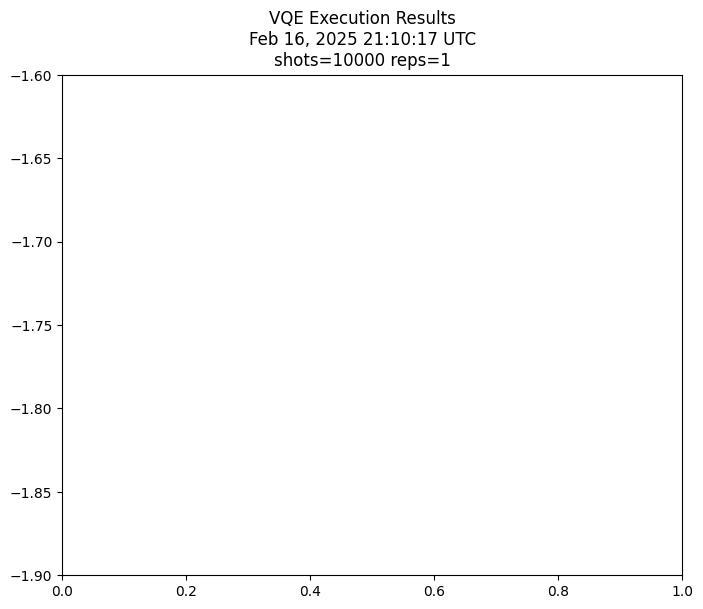

In [18]:
import time
from time import gmtime, strftime
from datetime import datetime
import matplotlib.pyplot as plt

NUM_SHOTS = num_shots
NUM_REPS = 1

# Get the current time formatted
def get_timestr():
    #timestr = strftime("%Y-%m-%d %H:%M:%S UTC", gmtime())
    timestr = strftime("%b %d, %Y %H:%M:%S UTC", gmtime())
    return timestr

# generate one-column figure with multiple bar charts, with shared X axis
def plot_results():
    
    cols = 1
    fig_w = 8.0
    
    numplots = 1
  
    rows = numplots
    
    # DEVNOTE: this calculation is based on visual assessment of results and could be refined
    # compute height needed to draw same height plots, no matter how many there are
    fig_h = 6.5 + 2.0 * (rows - 1) + 0.25 * (rows - 1)
    #print(fig_h)
    
    # create the figure into which plots will be placed
    fig, axs = plt.subplots(rows, cols, sharex=True, figsize=(fig_w, fig_h))
    
    # Create appropriate title
    suptitle = "VQE Execution Results"
    
    # append key metrics info to the title
    fulltitle = suptitle + f"\n{get_timestr()}"
    fulltitle += f"\nshots={NUM_SHOTS} reps={NUM_REPS}"

    # and add the title to the plot
    plt.suptitle(fulltitle)
    
    axi = 0
    xaxis_set = False
    
    if rows == 1:
        ax = axs
        axs = [ax]
        
    # For the y axis, choose the limits to be at least [0,40].
#     axs[axi].set_ylim([0, max(40,
#                       max(group_metrics_2["optimality_gap"]), 
#                       max(max(group_metrics_2["quantile_optgaps"]))
#                       ) * 1.1])

    #axs[axi].set_ylim([-2.0, -1.5])
    axs[axi].set_ylim([-1.9, -1.6])
    
    #axs[axi].bar(group_metrics["groups"], group_metrics_2["optimality_gap"], 0.8)
    
    print(f"{list(energy_results.keys())}")
    print(f"{list(energy_results.items())}")
    
    xdata = range(len(energy_results))
    xlabels = list(energy_results.keys())
    
    ydata = list(energy_results.items())
    
    #axs[axi].bar(group_metrics["groups"], group_metrics_2["optimality_gap"], 0.8)
    
    axs[axi].bar(xdata, er_averages, 0.7)

    # Plot the quantile optimality gaps as errorbars
    try:
#         q_vals = group_metrics_2['quantile_optgaps'] # list of lists; shape (number of circuit widths, 3)
#         # Indices are of the form (circuit width index, quantile index)
#         print(q_vals)
#         center_optgaps = [q_vals[i][1] for i in range(len(q_vals))]
#         down_error = [q_vals[i][0] - q_vals[i][1] for i in range(len(q_vals))]
#         up_error = [q_vals[i][1] - q_vals[i][2] for i in range(len(q_vals))]
#         errors = [up_error, down_error]

#         axs[axi].errorbar(group_metrics["groups"], center_optgaps, yerr = errors,
#                           ecolor = 'k', elinewidth = 1,barsabove=False, capsize=3,
#                           ls='',marker="D", markersize=5, mfc='c', mec='k', mew=0.5)
        
        #q_vals = group_metrics_2['quantile_optgaps'] # list of lists; shape (number of circuit widths, 3)
        # Indices are of the form (circuit width index, quantile index)
        #print(q_vals)
        center_optgaps = er_averages
        up_error = [er_averages[i] + er_stddevs[i] for i in range(len(er_averages))]
        down_error = [er_averages[i] - er_stddevs[i] for i in range(len(er_averages))]
        
        up_error = [er_stddevs[i] for i in range(len(er_averages))]
        down_error = [er_stddevs[i] for i in range(len(er_averages))]
        
        errors = [up_error, down_error]
        print(errors)

        axs[axi].errorbar(xdata, center_optgaps, yerr = errors,
                          ecolor = 'k', elinewidth = 1,barsabove=False, capsize=3,
                          ls='',marker="D", markersize=5, mfc='c', mec='k', mew=0.5)
        
    except Exception as e: print(e)

    #axs[axi].bar(group_metrics["groups"], group_metrics["avg_tr_depths"], 0.5, color='C9') 
    #axs[axi].set_ylabel(known_score_labels['approx_ratio'])
    axs[axi].set_ylabel('Lowest Ground State Energy')

    if rows > 0 and not xaxis_set:
        axs[axi].sharex(axs[rows-1])
        xaxis_set = True

    # Replacing legend settings. Might need to modify later
    # axs[axi].legend(['Degree 3', 'Degree -3'], loc='upper left') 
#     axs[axi].legend(['Optimality gap: metric', 'Optimality gap: quartiles'], loc='center left',
#                     bbox_to_anchor=(1, 0.5)) # For now, we are only plotting for degree 3, and not -3
    axi += 1
    
    # shared x axis label
    axs[rows - 1].set_xlabel('Backend System')
    
    ax.set_xticks(xdata)  
    plt.xticks(xdata, xlabels, color='black', rotation=45, ha='right', va='top', rotation_mode="anchor")
    
    fig.tight_layout() 
    
#     # save plot image to file
#     if save_plot_images:
#         save_plot_image(plt, f"{appname}-optgaps" + suffix, backend_id) 
            
#     # show the plot for user to see
#     if show_plot_images:
    plt.show()

plot_results()
        